In [1]:
# Printa a versão do Python
import sys
print(f"Versão do Python: {sys.version}")

Versão do Python: 3.11.7 (tags/v3.11.7:fa7a6f2, Dec  4 2023, 19:24:49) [MSC v.1937 64 bit (AMD64)]


In [2]:
# Importa as bibliotecas
import os
import pickle

import numpy as np
import pandas as pd

import torch as th

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

%matplotlib inline

In [3]:
from Enviroment.Settings import *
from Enviroment.Manager import Enviroment

In [17]:
def run_test(env, model, num_sim=10, main_seed=42):
    """ Realiza a simulação do modelo em um ambiente de simulação e retorna as probabilidades de bloqueio e as recompensas médias.

    Args:
        env (Enviroment): Ambiente de simulação.
        model (Model): Modelo a ser testado.
        num_sim (int): Número de simulações a serem realizadas.

    Returns:
        pbs (np.array): Probabilidades de bloqueio.
        reward (np.array): Recompensas médias.
    """

    number_of_nodes = env._number_of_nodes

    # # Verifica se model é uma string com o nome do modelo
    # if isinstance(model, str):
    #     if model not in ['RSA', 'SAR']:
    #         raise ValueError("Model must be 'RSA', 'SAR', a trained model from Stable Baselines 3 or a numpy array with the size equal to the number of nodes squared.")
    # else:
    #     if not hasattr(model, 'predict') and not isinstance(model, np.ndarray) and model.shape != (number_of_nodes**2,):
    #         raise ValueError("Model must be 'RSA', 'SAR', a trained model from Stable Baselines 3 or a numpy array with the size equal to the number of nodes squared.")
    
    # if isinstance(model, str):
    #     if model == 'RSA':
    #         print("Executando a avaliação do RSA")
    #     elif model == 'SAR':
    #         print("Executando a avaliação do SAR")
    # elif isinstance(model, np.ndarray):
    #     print("Executando a avaliação do GA")
    # else:
    #     print("Executando a avaliação do modelo")

    # Reseta a seed para garantir a reprodutibilidade dos resultados
    np.random.seed(main_seed)

    # Gera uma seed para cada simulação
    seeds = np.random.randint(0, 100_000, num_sim, dtype=int)

    # Cria um array para armazenar as probabilidades de bloqueio e as recompensas de cada simulação
    pbs = np.zeros(num_sim)
    rewards = np.zeros(num_sim)

    RSA_SAR_count = [0, 0]

    # Executa as simulações
    for i, seed in enumerate(seeds):

        print(f"Executando simulação {i+1} de {num_sim} com seed {seed}.")

        # Reseta o ambiente para garantir que ele esteja no estado inicial usando a seed
        state, info = env.reset(int(seed))

        # Executa a simulação
        while True:

            if isinstance(model, str):
                if model == 'RSA':
                    alg_heuristic = 0
                elif model == 'SAR':
                    alg_heuristic = 1
            elif isinstance(model, np.ndarray):
                alg_heuristic = model[state[1] + state[0] * 14]
            else:
                #alg_heuristic = model.predict(observation=state, deterministic=True)[0]
                alg_heuristic = model(th.tensor(state, dtype=th.float32)).argmax().item()

            RSA_SAR_count[alg_heuristic] += 1

            state, _, done, trunk, info = env.step(alg_heuristic)

            if (done or trunk) and rewards[i] == 0:
                rewards[i] = env._reward_episode
                break

        pbs[i] = info['total_number_of_blocks'] / info['last_request']

        print(f"Blocking Probability: {pbs[i]} | Reward: {rewards[i]} | Req: {info['last_request']}")

    print(f"\nBlocking Probability: {np.mean(pbs)} | Min: {np.min(pbs)} | Max: {np.max(pbs)} | +- {np.std(pbs)}")
    print(f"Reward: {np.mean(rewards)} | Min: {np.min(rewards)} | Max: {np.max(rewards)} | +- {np.std(rewards)}")
    print(f"RSA count: {RSA_SAR_count[0]} ({RSA_SAR_count[0]/(RSA_SAR_count[0]+RSA_SAR_count[1]):.2%}) | SAR count: {RSA_SAR_count[1]} ({RSA_SAR_count[1]/(RSA_SAR_count[0]+RSA_SAR_count[1]):.2%})")

    return {
        'pbs': pbs,
        'rewards': rewards,
        'RSA_SAR_count': RSA_SAR_count
    }

In [18]:
import torch.nn as nn

enviroment_type_test = {
    "Observation": "ODD-one-hot",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "40kReqs",
    "StartCond": "Empty"
}

# Cria o ambiente de simulação
env = Enviroment(network_load = 300, k_routes = 3, number_of_slots = 128, enviroment_type=enviroment_type_test, data_folder="DNN")

input_size = env.observation_space.n
output_size = env.action_space.n

In [19]:
class DNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DNN, self).__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.LeakyReLU(inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(inplace=True),
            nn.Linear(128, output_size),
            nn.Softmax(dim=1) if output_size > 2 else nn.Sigmoid()
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

In [20]:
def fitness_function(ga_instance, solution, solution_idx):

    # Carregando os pesos no modelo
    weight_index = 0
    for param in model.parameters():
        param.data.copy_(th.tensor(solution[weight_index:weight_index + param.numel()]).reshape(param.shape))
        weight_index += param.numel()

    model.eval()

    with th.no_grad():
        # Executando a simulação
        results = run_test(env, model, num_sim=5, main_seed=42)

        return results['rewards'].mean()
        
model = DNN(input_size, output_size)

# Quantidade de parâmetros do modelo
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Quantidade de parâmetros do modelo: {pytorch_total_params}")


Quantidade de parâmetros do modelo: 41346


In [24]:
# Treinando o modelo com o GA
from pygad import GA

# Parâmetros do GA
ga_param = {
    "num_generations": 300,   # Number of generations.
    "num_parents_mating": 6, # Number of solutions to be selected as parents in the mating pool.
    "fitness_func": fitness_function,
    "sol_per_pop": 50,  # Number of solutions in the population.
    "num_genes": pytorch_total_params, # Number of genes in the solution.
    "init_range_low": -1, # Lower bound of the random initial values of the genes.
    "init_range_high": 1, # Upper bound of the random initial values of the genes.
    "mutation_percent_genes": 2, # Percentage of genes to mutate. 
    "mutation_type": "random", # Type of mutation.
    "mutation_by_replacement": True, # Whether the mutation should be done by replacing the gene with a random value or adding a random value to the gene.
    "parent_selection_type": "tournament", # Type of parent selection.
    "crossover_type": "uniform", # Type of the crossover operator.
    "crossover_probability": 0.8, # Probability of crossover.
    "keep_elitism": 4, # Number of elites to keep in the population.
}

def on_gen(ga_instance):
    print("Generation : ", ga_instance.generations_completed)
    print("Fitness of the best solution :", ga_instance.best_solution()[1])

# Cria a instância do GA
ga_instance = GA(**ga_param,
        on_generation=on_gen,
        random_seed=42)


# Executa o GA
ga_instance.run()

# Obtém a melhor solução
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(f"Fitness of the best solution: {solution_fitness}")
print(f"Index of the best solution: {solution_idx}")
print(f"Best solution: {solution}")

# Carregando os pesos no modelo
weight_index = 0
for param in model.parameters():
    param.data.copy_(th.tensor(solution[weight_index:weight_index + param.numel()]).reshape(param.shape))
    weight_index += param.numel()

model.eval()

# Executando a simulação
results = run_test(env, model, num_sim=5, main_seed=42)


Executando simulação 1 de 5 com seed 15795.
Blocking Probability: 0.01205 | Reward: 39036.0 | Req: 40000
Executando simulação 2 de 5 com seed 860.
Blocking Probability: 0.01125 | Reward: 39100.0 | Req: 40000
Executando simulação 3 de 5 com seed 76820.
Blocking Probability: 0.013625 | Reward: 38910.0 | Req: 40000
Executando simulação 4 de 5 com seed 54886.
Blocking Probability: 0.0137 | Reward: 38904.0 | Req: 40000
Executando simulação 5 de 5 com seed 6265.
Blocking Probability: 0.012125 | Reward: 39030.0 | Req: 40000

Blocking Probability: 0.01255 | Min: 0.01125 | Max: 0.0137 | +- 0.0009590359742991919
Reward: 38996.0 | Min: 38904.0 | Max: 39100.0 | +- 76.72287794393534
RSA count: 42424 (21.21%) | SAR count: 157576 (78.79%)
Executando simulação 1 de 5 com seed 15795.
Blocking Probability: 0.011275 | Reward: 39098.0 | Req: 40000
Executando simulação 2 de 5 com seed 860.
Blocking Probability: 0.012375 | Reward: 39010.0 | Req: 40000
Executando simulação 3 de 5 com seed 76820.
Blocking Pro

KeyboardInterrupt: 

# GANN

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


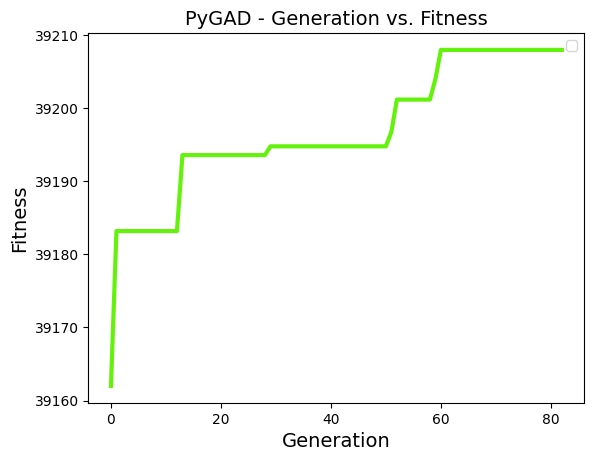

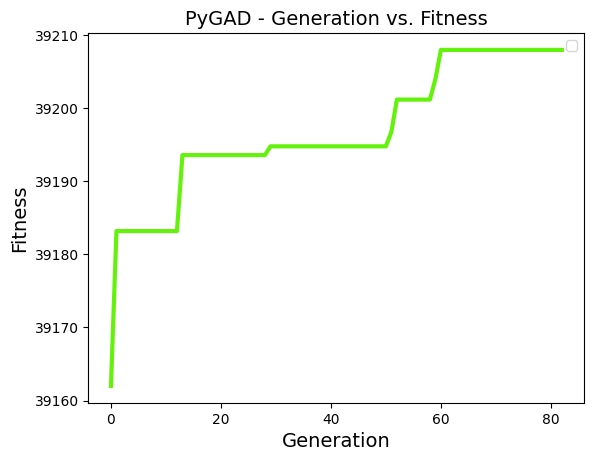

In [25]:
ga_instance.plot_fitness()

In [27]:
solution = ga_instance.best_solution()

solution

Executando simulação 1 de 5 com seed 15795.
Blocking Probability: 0.009 | Reward: 39280.0 | Req: 40000
Executando simulação 2 de 5 com seed 860.
Blocking Probability: 0.0106 | Reward: 39152.0 | Req: 40000
Executando simulação 3 de 5 com seed 76820.
Blocking Probability: 0.011 | Reward: 39120.0 | Req: 40000
Executando simulação 4 de 5 com seed 54886.
Blocking Probability: 0.010775 | Reward: 39138.0 | Req: 40000
Executando simulação 5 de 5 com seed 6265.
Blocking Probability: 0.010375 | Reward: 39170.0 | Req: 40000

Blocking Probability: 0.01035 | Min: 0.009 | Max: 0.011 | +- 0.0007055139970262817
Reward: 39172.0 | Min: 39120.0 | Max: 39280.0 | +- 56.441119762102524
RSA count: 15946 (7.97%) | SAR count: 184054 (92.03%)
Executando simulação 1 de 5 com seed 15795.
Blocking Probability: 0.00955 | Reward: 39236.0 | Req: 40000
Executando simulação 2 de 5 com seed 860.
Blocking Probability: 0.010875 | Reward: 39130.0 | Req: 40000
Executando simulação 3 de 5 com seed 76820.
Blocking Probability

(array([-0.41755041,  0.81512067, -0.32955036, ...,  0.92291816,
        -0.191453  , -0.59736882]),
 39208.0,
 0)

In [29]:
solution[0]

array([-0.41755041,  0.81512067, -0.32955036, ...,  0.92291816,
       -0.191453  , -0.59736882])

In [31]:
# sAlvando a melhor solução
with open('best_solution.pickle', 'wb') as f:
    pickle.dump(solution, f)

In [32]:
# sAlvando a melhor solução
with open('best_solution_solution.pickle', 'wb') as f:
    pickle.dump(solution[0], f)